<a href="https://colab.research.google.com/github/hernandick/DataScience/blob/master/DS_Proyecto_03_NLP_HERNAN_DICK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

Comenzamos instalando los paquetes necesarios para realizar el proyecto

In [ ]:
!spacy download es_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


In [ ]:
!pip install unidecode

# Exploración de datos

In [ ]:
#Importamos las librerías!
import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import nltk

#Esto sirve para configurar NLTK. La primera vez puede tardar un poco
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#Importamos el dataset completo.
import json
dataset = pd.read_json("dataset_es_dev.json", lines=True)

In [ ]:
#Forma del Dataset
dataset.shape

(5000, 8)

In [ ]:
#Primer vistazo del dataset.
dataset.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


En primer lugar se buscara describir el dataset respondiendo una serie de preguntas.

1. **¿La distribucion de puntajes es equitativa en nuestro dataset?**

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


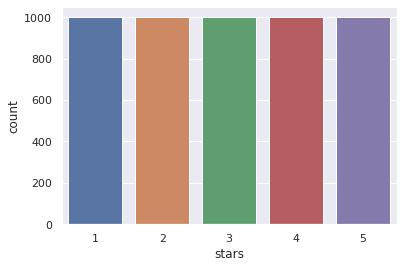

In [ ]:
#Distribucion de puntajes (estrellas) en el dataset.
sns.countplot(dataset['stars'])
plt.show()

Podemos ver que si, la distribucion de puntaje (stars) es equitativa para la muestra de datos. Esto sera clave para que el modelo de prediccion no esté sezgado.

A continuacion se sigue describiendo el dataset para netenderlo mejor.

In [ ]:
#Cantidad de productos diferentes en el dataset. 
dataset.product_id.describe()

count                   5000
unique                  4964
top       product_es_0066449
freq                       2
Name: product_id, dtype: object

Hay 4964 productos diferentes en el dataset.

El paso siguiente  es observar la cantidad de categorías en las que se clasifican estos productos.

In [ ]:
#Cantidad categorías en el datset.
dataset.product_category.describe()

count         5000
unique          30
top       wireless
freq           672
Name: product_category, dtype: object

Se puede observar que tenemos 30 categorías diferentes.

A continuacion un diagrama describe la distribucion de los productos en dichas categorías.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


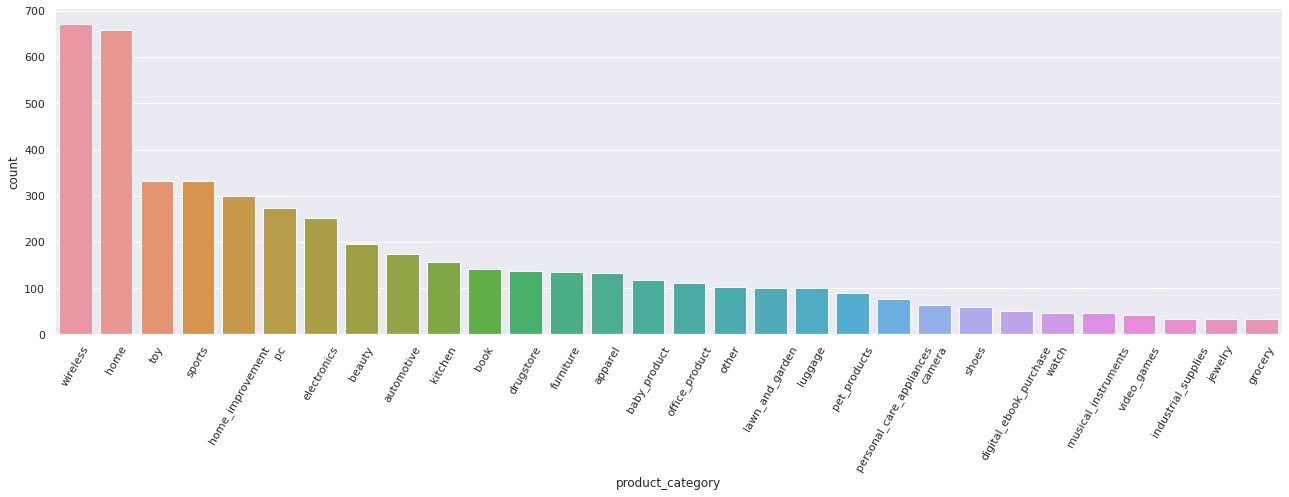

In [ ]:
#Distribucion de categorías en el datset.
plt.figure(figsize = (22,6))
sns.countplot(dataset['product_category'], order = dataset.product_category.value_counts().iloc[:30].index)
plt.xticks(rotation =60)

plt.show()

Podemos ver que las dos categorías mas populares son 'wierless' y 'home'. 

**Surge la pregunta: ¿Como se distribuyen los puntajes dentro de estas categorías?**


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


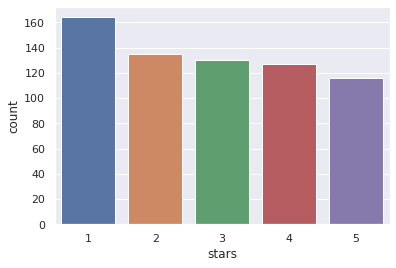

In [ ]:
#Distribucion de puntajes dentro de la categoría wireless.
data_wireless = dataset[dataset.product_category == 'wireless']
sns.countplot(data_wireless['stars'])
plt.show()

En el diagrama podemos observar los puntajes dentro de la categoría wireless. Podemos ver que dentro de la categoría los puntajes no estan perfectamente distribuidos. Un defasaje grande podria llegar a perjudicar el modelo final debido a que se podria generar un sezgo. Esto es por que si en determinada categoría tendríamos muchos puntajes negativos y hay palabras "negativas" que unicamente se asocian a la categoría, se veeria reflejado en el modelo.

En este caso como el defasaje de puntajes es pequeño, podemos asumir que el sezgo no es significativo.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


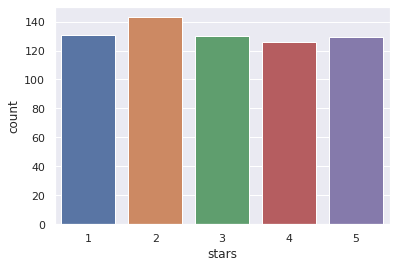

In [ ]:
#Distribucion de puntajes dentro de la categoría home.
data_home = dataset[dataset.product_category == 'home']
sns.countplot(data_home['stars'])
plt.show()

Se puede observar que en este caso el defasaje de puntajes dentro de la categoría es aún menor.
Dentro de las categorías la distribucion de puntajes no es equitativa. Sin embargo los defasajes de puntaje no son grandes y podemos concluir que no resultaran afectando el modelo final.

#Stemming

Se procede a aplicar las herramientas de procesamiento de lenguaje natural al dataset. En un primer caso aplicamos las herramientas de stemming de nltk para tokenizar las reseñas del dataset.


In [ ]:
# Se definen los stopwords en español
# Se elimina la palabra 'no' del arreglo ya que puede llegar a ser desiciva para catalogar referencias positivas o negativas.
from nltk.corpus import stopwords
stopwords = set(stopwords.words('spanish'))
stopwords.remove('no')

In [ ]:

# Importamos esta libreria que nos permite reemplzar caracteres
import re

#Definimos el stemmer
spanish_stemmer = nltk.stem.SnowballStemmer('spanish')

# Traemos nuevamente las stopwords
stopwords = nltk.corpus.stopwords.words('spanish')
stopwords.remove('no')


In [ ]:

# Recorremos todos los titulos y le vamos aplicando la Normalizacion y luega el Stemming a cada uno
titular_list=[]
for titular in dataset.review_body:
    # Vamos a reemplzar los caracteres que no sean letras por espacios
    titular=re.sub("[^a-zA-Z]"," ",str(titular))
    # Pasamos todo a minúsculas
    titular=titular.lower()
    # Tokenizamos para separar las palabras del titular
    titular=nltk.word_tokenize(titular)
    # Eliminamos las palabras de menos de 2 letras
    titular = [palabra for palabra in titular if len(palabra)>1]
    # Sacamos las Stopwords
    titular = [palabra for palabra in titular if not palabra in stopwords]
    
    ## Hasta acá Normalizamos, ahora a stemmizar
    # Aplicamos la funcion para buscar la raiz de las palabras
    titular=[spanish_stemmer.stem(palabra) for palabra in titular]
    # Por ultimo volvemos a unir el titular
    titular=" ".join(titular)
    # Vamos armando una lista con todos los titulares
    titular_list.append(titular)
    #dataset["titular_normalizado"] = titular_list

In [ ]:
# Agregamos al dataset una columna con la reseña stemmizada
dataset["body_stem"] = titular_list
dataset.tail()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,body_stem
4995,es_0179515,product_es_0158275,reviewer_es_0273644,5,Me ha encantado la cesta. Ha llegado impecable...,guadalupe,es,home,encant cest lleg impec tam util no pes firm qu...
4996,es_0894902,product_es_0953259,reviewer_es_0153773,5,Desempeña su función correctamente,calidad precio,es,camera,desemp funci correct
4997,es_0760496,product_es_0731995,reviewer_es_0171091,5,Me ha encantado la diadema! Las flores son tal...,Excelente,es,toy,encant diadem flor tal vien imag no ven an apl...
4998,es_0178380,product_es_0402051,reviewer_es_0686937,5,"A mi me gustan mucho las fundas TPU, ya que so...",Genial,es,wireless,gust fund tpu fund normal fin color hac vil bo...
4999,es_0810087,product_es_0684221,reviewer_es_0613091,5,El artículo ha cumplido con las expectativas q...,Buena calidad,es,apparel,art cul cumpl expect des


In [ ]:

# Recorremos todos los titulos y le vamos aplicando la Normalizacion y luega el Stemming a cada uno
titular_list=[]
for titular in dataset.review_title:
    # Vamos a reemplzar los caracteres que no sean letras por espacios
    titular=re.sub("[^a-zA-Z]"," ",str(titular))
    # Pasamos todo a minúsculas
    titular=titular.lower()
    # Tokenizamos para separar las palabras del titular
    titular=nltk.word_tokenize(titular)
    # Eliminamos las palabras de menos de 2 letras
    titular = [palabra for palabra in titular if len(palabra)>1]
    # Sacamos las Stopwords
    titular = [palabra for palabra in titular if not palabra in stopwords]
    
    ## Hasta acá Normalizamos, ahora a stemmizar
    # Aplicamos la funcion para buscar la raiz de las palabras
    titular=[spanish_stemmer.stem(palabra) for palabra in titular]
    # Por ultimo volvemos a unir el titular
    titular=" ".join(titular)
        # Vamos armando una lista con todos los titulares
    titular_list.append(titular)
    #dataset["titular_normalizado"] = titular_list

In [ ]:
#@title
dataset["title_stem"] = titular_list
dataset.tail()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,body_stem,title_stem
4995,es_0179515,product_es_0158275,reviewer_es_0273644,5,Me ha encantado la cesta. Ha llegado impecable...,guadalupe,es,home,encant cest lleg impec tam util no pes firm qu...,guadalup
4996,es_0894902,product_es_0953259,reviewer_es_0153773,5,Desempeña su función correctamente,calidad precio,es,camera,desemp funci correct,calid preci
4997,es_0760496,product_es_0731995,reviewer_es_0171091,5,Me ha encantado la diadema! Las flores son tal...,Excelente,es,toy,encant diadem flor tal vien imag no ven an apl...,excelent
4998,es_0178380,product_es_0402051,reviewer_es_0686937,5,"A mi me gustan mucho las fundas TPU, ya que so...",Genial,es,wireless,gust fund tpu fund normal fin color hac vil bo...,genial
4999,es_0810087,product_es_0684221,reviewer_es_0613091,5,El artículo ha cumplido con las expectativas q...,Buena calidad,es,apparel,art cul cumpl expect des,buen calid


In [ ]:
#Seleccionamos unicamente las columnas que nos importa analizar
dataset_stem=pd.concat([dataset.body_stem,dataset.title_stem,dataset.stars],axis=1)
dataset_stem.dropna(axis=0,inplace=True)  # Por si quedaron titulares vacios
dataset_stem.head()

,body_stem,title_stem,stars
0,malisim grand demasi aparat mal protector pantall,mal compr,1
1,no recib ped no devoluci,no recib,1
2,busc sistem no funcion bien abrazader llev aga...,no apriet bien manill,1
3,utilic broc menor di metr dobl vari si mantequ...,broc mantequill,1
4,no gust olor viej aspect mal,no gust,1


In [ ]:
#creamos una columna auxiliar uniendo el titulo y la reseña
dataset_stem['body_and_title'] = dataset_stem['body_stem'] + dataset_stem['title_stem']
dataset_stem

,body_stem,title_stem,stars,body_and_title
0,malisim grand demasi aparat mal protector pantall,mal compr,1,malisim grand demasi aparat mal protector pant...
1,no recib ped no devoluci,no recib,1,no recib ped no devolucino recib
2,busc sistem no funcion bien abrazader llev aga...,no apriet bien manill,1,busc sistem no funcion bien abrazader llev aga...
3,utilic broc menor di metr dobl vari si mantequ...,broc mantequill,1,utilic broc menor di metr dobl vari si mantequ...
4,no gust olor viej aspect mal,no gust,1,no gust olor viej aspect malno gust
...,...,...,...,...
4995,encant cest lleg impec tam util no pes firm qu...,guadalup,5,encant cest lleg impec tam util no pes firm qu...
4996,desemp funci correct,calid preci,5,desemp funci correctcalid preci
4997,encant diadem flor tal vien imag no ven an apl...,excelent,5,encant diadem flor tal vien imag no ven an apl...
4998,gust fund tpu fund normal fin color hac vil bo...,genial,5,gust fund tpu fund normal fin color hac vil bo...


In [ ]:
#creamos una etiqueta para saber si la reseña fue positiva o negativa
dataset_stem['review'] = ['negative' if x <= 2 else 'positive' for x in dataset_stem['stars']]
dataset_stem

,body_stem,title_stem,stars,body_and_title,review
0,malisim grand demasi aparat mal protector pantall,mal compr,1,malisim grand demasi aparat mal protector pant...,negative
1,no recib ped no devoluci,no recib,1,no recib ped no devolucino recib,negative
2,busc sistem no funcion bien abrazader llev aga...,no apriet bien manill,1,busc sistem no funcion bien abrazader llev aga...,negative
3,utilic broc menor di metr dobl vari si mantequ...,broc mantequill,1,utilic broc menor di metr dobl vari si mantequ...,negative
4,no gust olor viej aspect mal,no gust,1,no gust olor viej aspect malno gust,negative
...,...,...,...,...,...
4995,encant cest lleg impec tam util no pes firm qu...,guadalup,5,encant cest lleg impec tam util no pes firm qu...,positive
4996,desemp funci correct,calid preci,5,desemp funci correctcalid preci,positive
4997,encant diadem flor tal vien imag no ven an apl...,excelent,5,encant diadem flor tal vien imag no ven an apl...,positive
4998,gust fund tpu fund normal fin color hac vil bo...,genial,5,gust fund tpu fund normal fin color hac vil bo...,positive


Ahora que nuestro dataset está listo para trabajar luego de haber creado columnas auxiliares y eliminado las que no usaremos. Ahora nos proponemos responder la siguiente pregunta: 

**¿Que palabras son las más utilizadas en las reseñas negativas? ¿Y en las positivas?**

#Analisis de Reseñas Negativas con Stemming

En esta seccion analizaremos las palabras mas frecuentes a encontrar en reseñas "negativas". Continuaremos trabajando con el dataset en el que se trabajo con stemming.

In [ ]:
#@title
dataset_negative = dataset_stem[dataset_stem.review=='negative']
dataset_negative.head()

,body_stem,title_stem,stars,body_and_title,review
0,malisim grand demasi aparat mal protector pantall,mal compr,1,malisim grand demasi aparat mal protector pant...,negative
1,no recib ped no devoluci,no recib,1,no recib ped no devolucino recib,negative
2,busc sistem no funcion bien abrazader llev aga...,no apriet bien manill,1,busc sistem no funcion bien abrazader llev aga...,negative
3,utilic broc menor di metr dobl vari si mantequ...,broc mantequill,1,utilic broc menor di metr dobl vari si mantequ...,negative
4,no gust olor viej aspect mal,no gust,1,no gust olor viej aspect malno gust,negative


In [ ]:

filtrar = []
if True:
    filtrar.append("u")
    filtrar.append("new")

todos_titulares_negativos = []
for i in range(dataset_negative.shape[0]):
    titular = dataset_negative.iloc[i].body_and_title
    titular = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(titular)
    titular = [word for word in titular if word not in stopwords]
    titular = [word for word in titular if word not in filtrar]

    todos_titulares_negativos.append(titular)

In [ ]:
# Esta celda convierte una lista de listas en una unica lista
todos_titulares_negativos = list(itertools.chain(*todos_titulares_negativos))



In [ ]:
freq_negativos = nltk.FreqDist(todos_titulares_negativos)


In [ ]:
df_neg = pd.DataFrame(list(freq_negativos.items()), columns = ["Word","Frequency"])
df_neg.head()

,Word,Frequency
0,malisim,16
1,grand,55
2,demasi,89
3,aparat,21
4,mal,318


In [ ]:
# ordenar por frecuencia
df_neg.sort_values('Frequency',ascending=False, inplace = True)
df_neg.head()
df_neg.reset_index(drop = True, inplace=True)
df_neg.head()

,Word,Frequency
0,no,2379
1,lleg,399
2,compr,367
3,bien,355
4,product,333


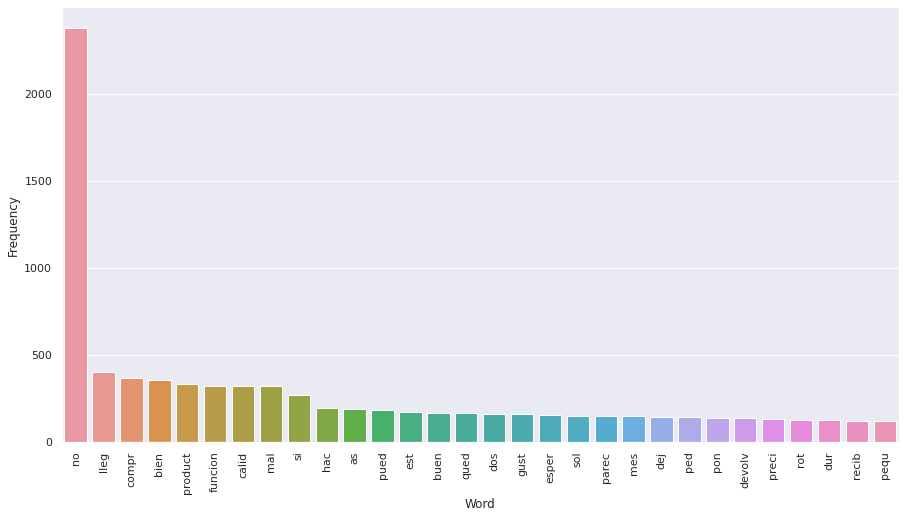

In [ ]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_neg.iloc[:30].Word, y = df_neg.iloc[:30].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

En este grafico se observan las palabras más utilizadas en reseñas negativas y su frecuencia

#Analisis de Reseñas Positivas con Stemming
En esta seccion analizaremos las palabras mas frecuentes a encontrar en reseñas "positivas". Continuaremos trabajando con el dataset en el que se trabajo con stemming.


In [ ]:

dataset_positive = dataset_stem[dataset_stem.review =='positive']
dataset_positive.head()

,body_stem,title_stem,stars,body_and_title,review
2000,gust color tej calid espum recomend,encaj,3,gust color tej calid espum recomendencaj,positive
2001,lleg pid pequ pens no cab tant cos cm fot mate...,simpl,3,lleg pid pequ pens no cab tant cos cm fot mate...,positive
2002,gust product,buen product,3,gust productbuen product,positive
2003,despeg pid hech sid coc,bien,3,despeg pid hech sid cocbien,positive
2004,no parec tampoc especif animal apriet pued val...,basic,3,no parec tampoc especif animal apriet pued val...,positive


In [ ]:

todos_titulares_positivos = []
for i in range(dataset_positive.shape[0]):
    titular = dataset_positive.iloc[i].body_and_title
    titular = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(titular)
    titular = [word for word in titular if word not in stopwords]
   

    todos_titulares_positivos.append(titular)

In [ ]:
todos_titulares_positivos = list(itertools.chain(*todos_titulares_positivos))

In [ ]:
freq_positivos = nltk.FreqDist(todos_titulares_positivos)


In [ ]:
df_pos = pd.DataFrame(list(freq_positivos.items()), columns = ["Word","Frequency"])
# ordenar por frecuencia
df_pos.sort_values('Frequency',ascending=False, inplace = True)
df_pos.reset_index(drop = True, inplace=True)
df_pos.head()


,Word,Frequency
0,no,1669
1,bien,949
2,buen,857
3,calid,687
4,preci,573


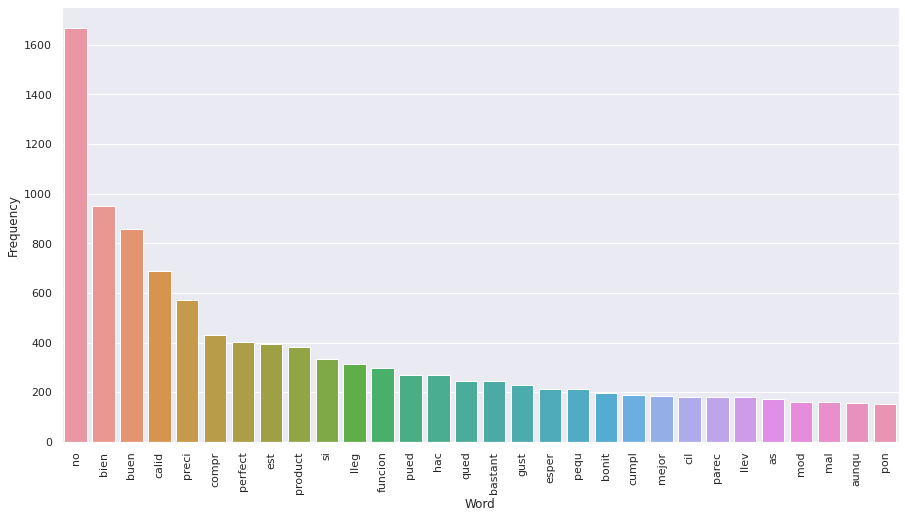

In [ ]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_pos.iloc[:30].Word, y = df_pos.iloc[:30].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

En este grafico se observan las palabras más utilizadas en reseñas positivas y su frecuencia

#Vectorizar Dataset Stem

A partir de aqui trabajaremos para crear un modelo de predicion que trate de adivinar el puntaje obtenido en base a la reseña escrita. Primero procederemos a vectorizar el dataset con el que venimos trabajando.


  

In [ ]:
# Tomamso la lista de palabras y el vector que nos dice si es o no sarcastico el titulo
list_titulos = list(dataset_stem['body_stem'].values)
stars = dataset_stem['stars'].values



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Usaremos solo las 1100 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features=1100

# Es decir que cada instancia tendrá 1100 features
cou_vec=CountVectorizer(max_features=max_features) # stop_words="english" , ngram_range=(1, 2)

# Modelos Benchmark Stem
Crearemos tres modelos de benchmark para poder comparar los resultados.

In [ ]:
matriz_titulos = cou_vec.fit_transform(list_titulos)

# Tomamos las palabras
all_words = cou_vec.get_feature_names()

# Vizualizamos las 50 palabras mas usadas
print("50 palabras mas usadas: ",all_words[0:50])

50 palabras mas usadas:  ['abaj', 'abiert', 'abre', 'abrir', 'abrirl', 'absolut', 'acab', 'accesori', 'aceit', 'acept', 'acert', 'aconsej', 'acopl', 'acord', 'activ', 'ada', 'adapt', 'adecu', 'adem', 'adhes', 'adhier', 'adjunt', 'ado', 'adquir', 'adult', 'afil', 'agarr', 'agrad', 'agradec', 'agu', 'aguant', 'agujer', 'ah', 'ahor', 'ahorr', 'air', 'ajust', 'alg', 'algui', 'algun', 'alimentaci', 'almacen', 'almoh', 'alta', 'altavoz', 'alto', 'altur', 'alumbr', 'amarill', 'amazon']


In [ ]:
#Creamos sets de train y de test de nuestro dataset vecorizado
x = matriz_titulos.toarray()
y = stars

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [ ]:
#Definimos la matriz de confusion
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion(ytest,y_pred):
    names=["1","2",'3','4','5']
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(xtrain,ytrain)
print("acc : ", nb.score(xtest,ytest))

acc :  0.306


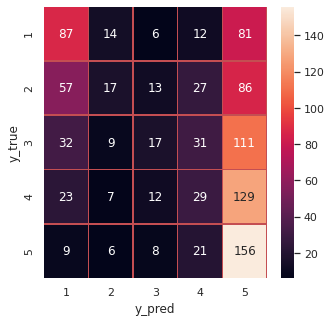

In [ ]:
y_pred=nb.predict(xtest)
confusion(ytest,y_pred)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators = 50, random_state=42)
rf.fit(xtrain,ytrain)
print("acc: ",rf.score(xtest,ytest))

acc:  0.391


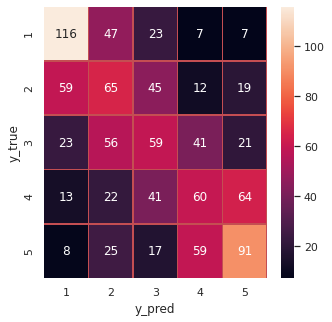

In [ ]:

y_pred=rf.predict(xtest)
confusion(ytest,y_pred)

In [ ]:
#@title
# Notar que en vez de utilizar SVC, vamos a usar LinearSVC. 
# Para el Kernel Lineal, esta función es MUCHO mas rapida que la tradicional SVC.
from sklearn.svm import LinearSVC

svc = LinearSVC(C = 1)
svc.fit(xtrain,ytrain)
svc.score(xtest,ytest)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.398

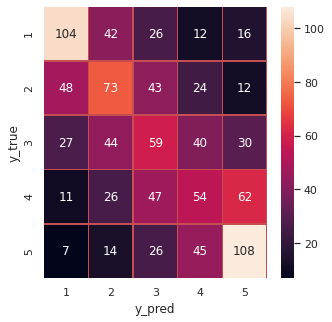

In [ ]:
y_pred = svc.predict(xtest)
confusion(ytest,y_pred)

Podemos observar de que los tres modelos implementados obtuvieron un puntaje relativamente bajo en los modelos de benchmark.

#Lemmatization
En la siguiente seccion se trabajará con una tecnica distinta a stemming llamada lemmatization. En vez de eliminar la terminacion de las palabras para omitir conjugaciones, esta funcion reemplaza las palabras con su forma no conjugada. Se podría decir que es una solución un poco mas elegante que stemming.

In [ ]:
import spacy
import unidecode

from spacy.lemmatizer import Lemmatizer
import spacy
import re
spacy.prefer_gpu()

nlp = spacy.load('es_core_news_sm')

In [ ]:
dataset['body_lem'] = dataset["review_body"].apply(lambda row: " ".join([w.lemma_ for w in nlp(row)]))
titular_list=[]
for titular in dataset.review_body:
    #Removemos los accentos
    titular = unidecode.unidecode(titular)
    # Vamos a reemplzar los caracteres que no sean letras por espacios
    titular=re.sub("[^a-zA-Z]"," ",str(titular))
    # Pasamos todo a minúsculas
    titular=titular.lower()
    # Tokenizamos para separar las palabras del titular
    titular=nltk.word_tokenize(titular)
    # Eliminamos las palabras de menos de 2 letras
    titular = [palabra for palabra in titular if len(palabra)>1]
    # Sacamos las Stopwords
    titular = [palabra for palabra in titular if not palabra in stopwords]
    
    ## Hasta acá Normalizamos, ahora a stemmizar
    # Aplicamos la funcion para buscar la raiz de las palabras
  
    # Por ultimo volvemos a unir el titular
    titular=" ".join(titular)
    # Vamos armando una lista con todos los titulares
    titular_list.append(titular)
    #dataset["titular_normalizado"] = titular_list

dataset["body_lem_clean"] = titular_list


In [ ]:
#Creamos un nuevo dataset con enunciados lemmatiszados
dataset_lem = dataset[['stars','body_lem_clean']]
dataset_lem['review'] = ['negative' if x <= 2 else 'positive' for x in dataset_stem['stars']]
dataset_lem


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,stars,body_lem_clean,review
0,1,malisimo grande demasiado aparatoso mal protec...,negative
1,1,no recibido pedido no devolucion,negative
2,1,buscar sistema no funciona bien abrazadera lle...,negative
3,1,utilice brocas menor diametro doblaron varias ...,negative
4,1,no gusta olor viejo aspecto malo,negative
...,...,...,...
4995,5,encantado cesta llegado impecable tamano util ...,positive
4996,5,desempena funcion correctamente,positive
4997,5,encantado diadema flores tal vienen imagen no ...,positive
4998,5,gustan fundas tpu fundas normalmente finas col...,positive


#Analisis de Reseñas Negativas con Lemmatization
Nuevamente nos pronemos a analizar las palabras mas utilizadas en reseñas negativas y positivas, esta vez con el dataset "lemmatizado" para observar si hay diferencias entre ambas tecnicas.

En esta seccion analizaremos las palabras mas frecuentes a encontrar en reseñas "negativas". Continuaremos trabajando con el dataset en el que se trabajo con lemmatization.

In [ ]:

dataset_negative_lem = dataset_lem[dataset_lem.review=='negative']
dataset_negative_lem.head()

,stars,body_lem_clean,review
0,1,malisimo grande demasiado aparatoso mal protec...,negative
1,1,no recibido pedido no devolucion,negative
2,1,buscar sistema no funciona bien abrazadera lle...,negative
3,1,utilice brocas menor diametro doblaron varias ...,negative
4,1,no gusta olor viejo aspecto malo,negative


In [ ]:
todos_titulares_negativos = []
for i in range(dataset_negative_lem.shape[0]):
    titular = dataset_negative_lem.iloc[i].body_lem_clean
    titular = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(titular)
    titular = [word for word in titular if word not in stopwords]
   

    todos_titulares_negativos.append(titular)

In [ ]:
# Esta celda convierte una lista de listas en una unica lista
todos_titulares_negativos = list(itertools.chain(*todos_titulares_negativos))

freq_negativos = nltk.FreqDist(todos_titulares_negativos)

df_neg1 = pd.DataFrame(list(freq_negativos.items()), columns = ["Word","Frequency"])
df_neg1.head()


,Word,Frequency
0,malisimo,11
1,grande,41
2,demasiado,76
3,aparatoso,2
4,mal,109


In [ ]:
# ordenar por frecuencia
df_neg1.sort_values('Frequency',ascending=False, inplace = True)
df_neg1.reset_index(drop = True, inplace=True)
df_neg1.head()

,Word,Frequency
0,no,2236
1,bien,352
2,mas,340
3,si,306
4,producto,299


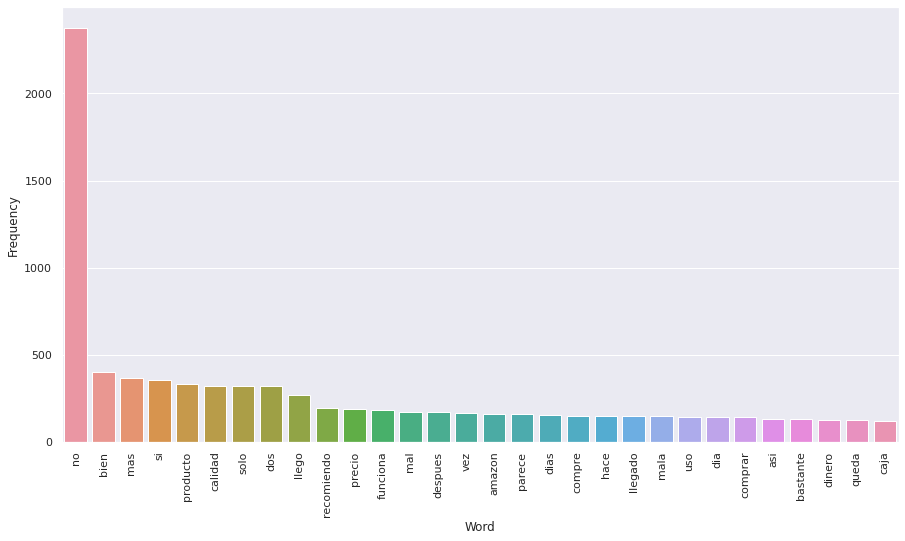

In [ ]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_neg1.iloc[:30].Word, y = df_neg.iloc[:30].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

En este grafico se observan las palabras más utilizadas en reseñas negativas y su frecuencia. Notamos que algunas de las palabras son diferentes a cuando usamos stemmig.

#Analisis de Reseñas Positivas con Lemmatization

En esta seccion analizaremos las palabras mas frecuentes a encontrar en reseñas "Positivas". Continuaremos trabajando con el dataset en el que se trabajo con lemmatization.

In [ ]:
dataset_positive_lem = dataset_lem[dataset_lem.review =='positive']
dataset_positive_lem.head()

,stars,body_lem_clean,review
2000,3,gusto color tejido calidad espuma recomendable,positive
2001,3,llegado rapido mas pequena pensaba no caben ta...,positive
2002,3,gustado producto,positive
2003,3,despega rapido hecho sido cocerlo,positive
2004,3,no parece tampoco especifico animales aprieto ...,positive


In [ ]:

todos_titulares_positivos = []
for i in range(dataset_positive_lem.shape[0]):
    titular = dataset_positive_lem.iloc[i].body_lem_clean
    titular = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(titular)
    titular = [word for word in titular if word not in stopwords]
   

    todos_titulares_positivos.append(titular)

In [ ]:
todos_titulares_positivos = list(itertools.chain(*todos_titulares_positivos))

In [ ]:
freq_positivos = nltk.FreqDist(todos_titulares_positivos)


In [ ]:
df_pos1 = pd.DataFrame(list(freq_positivos.items()), columns = ["Word","Frequency"])
# ordenar por frecuencia
df_pos1.sort_values('Frequency',ascending=False, inplace = True)
df_pos1.reset_index(drop = True, inplace=True)
df_pos1.head()


,Word,Frequency
0,no,1617
1,bien,978
2,mas,593
3,calidad,551
4,precio,466


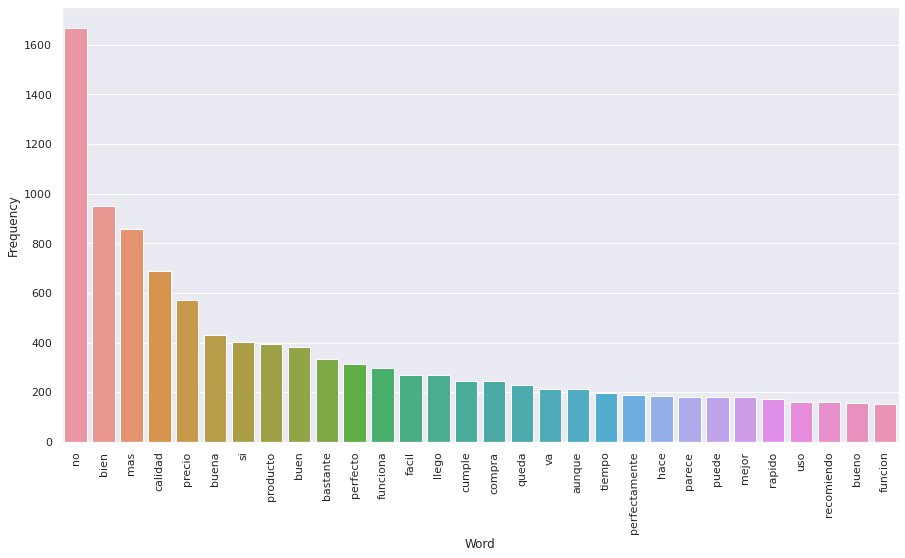

In [ ]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_pos1.iloc[:30].Word, y = df_pos.iloc[:30].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

En este grafico se observan las palabras más utilizadas en reseñas positivas y su frecuencia. Notamos que algunas de las palabras son diferentes a cuando usamos stemmig.

**Pregunta: ¿Obtenemos listas distintas de palabras mas usadas si tokenizamos con lematizacion o con stemmizacion?**

In [ ]:
#Reseñas positivas
print("lem",df_pos1.head())

print("stem",df_pos.head())

lem       Word  Frequency
0       no       1617
1     bien        978
2      mas        593
3  calidad        551
4   precio        466
stem     Word  Frequency
0     no       1669
1   bien        949
2   buen        857
3  calid        687
4  preci        573


In [ ]:
#Reseñas negativas
print("lem",df_neg1.head())

print("stem",df_neg.head())

lem        Word  Frequency
0        no       2236
1      bien        352
2       mas        340
3        si        306
4  producto        299
stem       Word  Frequency
0       no       2379
1     lleg        399
2    compr        367
3     bien        355
4  product        333


En el analisis comparativo notamos en las 5 palabras mas utilizadas en las reseñas positivas y negativas que estas varían levemente de acuerdo a la tecnica que se utilize para tokenizar. Sin embargo observando los gráficos notamos que estas diferencias no son muy significativas ya que las frecuencias en ciertas palabras fluctuan poco. Optamos por seguir trabajando con el dataset en el que utilizamos lemmatization ya que se considera la solucion mas "elegante".

#Vectorizar Dataset Lem



In [ ]:
# Tomamso la lista de palabras y el vector que nos dice si es o no sarcastico el titulo
list_titulos = list(dataset_lem['body_lem_clean'].values)
stars = dataset_lem['stars'].values

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Usaremos solo las 1000 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features=1000

# Es decir que cada instancia tendrá 1000 features
cou_vec=CountVectorizer(max_features=max_features) # stop_words="english" , ngram_range=(1, 2)

#Modelos Benchmark (para el dataset Lem)

Nuevamente procedemos a realizar modelos de benchmark utilizando modelos de prediccion simples sin optimizacion de hiperparametros.

In [ ]:
matriz_titulos = cou_vec.fit_transform(list_titulos)

# Tomamos las palabras
all_words = cou_vec.get_feature_names()

# Vizualizamos las 50 palabras mas usadas
print("50 palabras mas usadas: ",all_words[0:50])

50 palabras mas usadas:  ['abajo', 'abierta', 'abierto', 'abre', 'abrir', 'acaba', 'acabado', 'acabados', 'acabo', 'accesorios', 'aceite', 'aceptable', 'aconsejo', 'adapta', 'adaptador', 'adecuado', 'ademas', 'adhesivo', 'agradable', 'agua', 'aguanta', 'agujero', 'agujeros', 'ahi', 'ahora', 'aire', 'ajusta', 'ajuste', 'alguien', 'algun', 'alguna', 'alta', 'altavoz', 'alto', 'altura', 'amazon', 'ancho', 'ano', 'anos', 'antena', 'anterior', 'anuncio', 'apaga', 'aparato', 'aparece', 'aparte', 'apenas', 'aplicacion', 'app', 'apple']


In [ ]:
#creamos sets de test y de train
x = matriz_titulos.toarray()
y = stars

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion(ytest,y_pred):
    names=["1","2",'3','4','5']
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(xtrain,ytrain)
print("acc : ", nb.score(xtest,ytest))

acc :  0.318


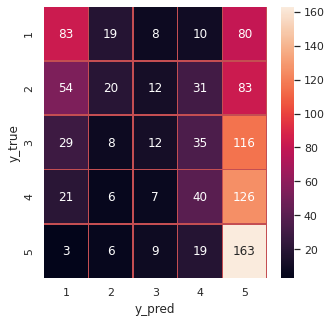

In [ ]:
y_pred=nb.predict(xtest)
confusion(ytest,y_pred)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators = 50, random_state=42)
rf.fit(xtrain,ytrain)
print("acc: ",rf.score(xtest,ytest))

acc:  0.389


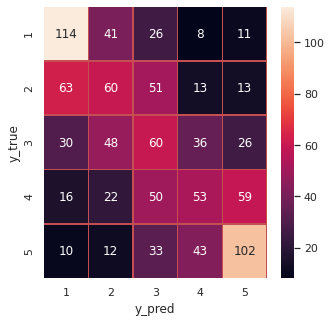

In [ ]:

y_pred=rf.predict(xtest)
confusion(ytest,y_pred)

In [ ]:

# Notar que en vez de utilizar SVC, vamos a usar LinearSVC. 
# Para el Kernel Lineal, esta función es MUCHO mas rapida que la tradicional SVC.
from sklearn.svm import LinearSVC

svc = LinearSVC(C = 1)
svc.fit(xtrain,ytrain)
svc.score(xtest,ytest)

0.395

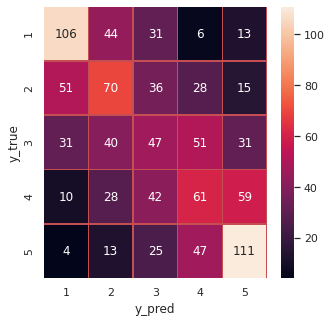

In [ ]:
y_pred = svc.predict(xtest)
confusion(ytest,y_pred)

Podemos observar de que los tres modelos implementados obtuvieron un puntaje relativamente bajo en los modelos de benchmark. Esperamos obtener mejores modelos cuando trabajemos con optimización de hiperparametros. Seguiremos trabajando con un modelo de SVC ya que fue el que obtuvo mejores resultados en la etapa de benchmark.


# Modelos de prediccion

En esta seccion desarrollaremos un modelo para predecir la cantidad de estrellas de un producto en base a la reseña del usuario. Usaremos SVC para el modelo y optimizaremos los hiperparametros utilizando grid search.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.datasets import load_breast_cancer 
from sklearn.svm import SVC 

In [ ]:
from sklearn.model_selection import GridSearchCV 

# Definimos rangos de los hiperparametros
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(xtrain, ytrain) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.215, total=  31.8s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.8s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.223, total=  31.9s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.204, total=  31.6s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.204, total=  31.4s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.206, total=  31.3s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.292, total=  30.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.329, total=  29.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.321, total=  29.3s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.320, total=  28.8s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 57.6min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [ ]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 


{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [ ]:
grid_predictions = grid.predict(xtest) 
  
# print classification report 
print(classification_report(ytest, grid_predictions)) 

              precision    recall  f1-score   support

           1       0.52      0.55      0.53       200
           2       0.36      0.39      0.38       200
           3       0.31      0.31      0.31       200
           4       0.35      0.31      0.33       200
           5       0.56      0.56      0.56       200

    accuracy                           0.42      1000
   macro avg       0.42      0.42      0.42      1000
weighted avg       0.42      0.42      0.42      1000



Observamos que los resultados del modelo son mas altos optimizando los hiperparametros. De todas formas se considera que un accuracy del 0.42 es relativamente bajo. Se cree que es una tarea dificil calcular exactamente la cantidad de estrellas que recibe un producto en base a su reseña ya que esto es algo totalmente subjetivo. Por ejemplo las palabras utilizadas en reseñas de 1 o 2 estrellas pueden ser muy similares. Por eso creemos que podria ser mas factible un modelo que prediga si una reseña fue negativa (una o dos estrellas) o positiva (tres o mas) en base a lo que escribió el usuario.

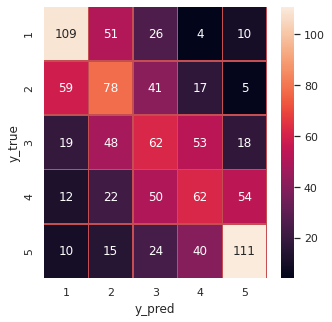

In [ ]:
y_pred = grid.predict(xtest)
confusion(ytest,y_pred)

Podemos ver en la matriz de confusion que hay cierto grado de aciertos en el modelo, sobre todo en los extremos, sin embargo notamos que al modelo le cuesta diferenciar entre puntajes similares (1 y 2, 4 y 5)

In [ ]:
#Validacion Cruzada
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC 

model = SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

SVC_score = cross_validate(model, x, y, cv=5)

print(SVC_score)

{'fit_time': array([28.5004468 , 28.17597198, 28.17889667, 29.20987606, 28.57995653]), 'score_time': array([6.14587498, 6.1044054 , 6.14080763, 6.14931798, 6.16398048]), 'test_score': array([0.428, 0.425, 0.433, 0.415, 0.425])}


La validacion cruzada nos confirma que los resultados del modelo no estan sezgados por la muestras de prueba y entrenamiento.

#Modelo de Prediccion Binario

En la siguiente seccion desarrollaremos un modelo que prediga si una reseña fue negativa (una o dos estrellas) o positiva (tres o mas). Crearemos nuevas etiquetas y seguiremos trabajando con principios similares a los modelos anteriores.

Se espera que para este modelo se obtendrán resultados considerablemente mejores que en el modelo anterior debido a que se estan simplificando los datos de manera considerable agrupandolos en menos categorías.


In [ ]:
#Creamos nuevas etiquetas. 1 si es una reseña positiva, 0 si es negativa
y = pd.get_dummies(dataset_lem['review'])
y = y['positive']

In [ ]:
#Modelo Benchmark
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

model = SVC() 
model.fit(xtrain, ytrain) 
  
# print prediction results 
predictions = model.predict(xtest) 
print(classification_report(ytest, predictions)) 

              precision    recall  f1-score   support

           0       0.75      0.65      0.70       400
           1       0.79      0.85      0.82       600

    accuracy                           0.77      1000
   macro avg       0.77      0.75      0.76      1000
weighted avg       0.77      0.77      0.77      1000



In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(ytest, predictions)

array([[261, 139],
       [ 88, 512]])

In [ ]:
from sklearn.model_selection import GridSearchCV 

# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(xtrain, ytrain) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.600, total=  20.9s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.9s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.600, total=  21.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   41.9s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.600, total=  21.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.600, total=  21.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.600, total=  21.3s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.700, total=  17.6s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.699, total=  17.8s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.676, total=  17.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.665, total=  17.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 35.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [ ]:
# print mejor combinacion de hiperparametros 
print(grid.best_params_) 
  
# print como se ve el modelo despuees de ajustar los hiperparametros.
print(grid.best_estimator_) 


{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [ ]:
grid_predictions = grid.predict(xtest) 
  
# print reeporte de clasificacion
print(classification_report(ytest, grid_predictions)) 

              precision    recall  f1-score   support

           0       0.75      0.68      0.72       400
           1       0.80      0.85      0.82       600

    accuracy                           0.78      1000
   macro avg       0.78      0.77      0.77      1000
weighted avg       0.78      0.78      0.78      1000



In [ ]:
confusion_matrix(ytest, grid_predictions)

array([[273, 127],
       [ 90, 510]])

Luego de entrenar el modelo podemos observar que obtuvo resultados bastante satisfactorios. Alcanzo un accuracy de 0.78 lo cual se puede considerar accetable para un modelo de clasificacion de este tipo ya que es lo suficientemente alto para ser confiable pero no demasiado lo cual podrìa significar un sobre ajuste. De todos los modelos generados en este notebook se podría considerar como el más peretinente ya que por su accuracy se podria considerar certero y podria brindar informacion sobre si un consumidor esta satisfecho o no con su compra representandolo de forma booleana.





#Investigación

En relacion a cuanto se podría profundizar el analisis que se llevo a cabo en este notebook surgen varias ideas basadas en el articulo ¨The Multilingual Amazon Reviews Corpus" por Phillip Keung, Yichao Lu y Gyorgy Szarvas de la universidad University of Washington, Allen Institute for AI (https://arxiv.org/pdf/2010.02573v1.pdf#page=6&zoom=100,402,918)

En dicho articulo se lleva a cabo una investigacion en vias similares a la de este notebook pero de forma mucho más extensa. 

En primer lugar el estudio se lleva a cabo para los 5 idiomas en los que está disponible el Multilingual Amazon Review Corpus. Para cada idioma se generan modelos de predicción utilizando el cuerpo de la reseña, el titulo y la categoría del producto y se generan utilizando distintas combinaciones de esta información. A su vez se generan modelos binarios y de calificacion de 1 al 5 tal como se llevó a cabo en este notebook. 

El articulo menciona que en la investigacion se llevo a cabo un procesamiento de texto más profundo del que se alcanzo en este notebook, por ejemplo, se aplico un algoritmo de reconocimiento de idioma para asegurarse de que las reseñas fueran en el idioma indicado. También se eliminaron algunas reseñas de productos repetidos para eliminar posibles sezgos. 

En cuanto a los resultados los obtenidos por este estudio tienen un orden de magnigud similar a los obtenidos en el notebook. Es entendible ya que es producto de una investigacion muchisimo mas extensa (proyecto de investigacion de maestría). El objetivo de este notebook más que conseguir los mejores resultados fue llevar a cabo la aplicacion de las herramientas provistas por el curso. Para el modelo de clasificacion de 5 estrellas el articulo menciona un accuracy de 0.47 lo cual nos confirma que el resultado de 0.42 de nuestro no está muy alejado del mejor modelo que se podría obtener. Por otro lado para la prediccion binaria se alcanza un resultado (0.92) considerablemente más alto del alcanzado en este notebook (0.78), dejando en evidencia que se podría profundizar en el desarrollo de este modelo.

Por ultimo mencionar que en el principio de este trabajo se esperaba alcanzar resultados similares a los obtenidos. Claramente se esperaba que el modelo de prediccion de puntajes de 1 a 5 iba a ser menos certero que el binario y así resultó siendo. Sin embargo se esperaba obtener un resultado mayor en el accuracy de el modelo binario ya que en el paper consultado se llega aun orden del noveno decil y en este notebook se alcanzo simplemente el septimo.